

# Comparing the SVD and gradient descent methods for solving 2-dimensional linear regression

Linear regression is a classic problem in numerical analysis. There are countless applications, as well as many different approaches to solving the problem. We will look at two such methods and try to compare them. But first, let us define the specific problem we have to solve. 

Let $X = \{(x_i, y_i) : i=1, 2, ..., n\} \subset {\rm I\!R}^2$ be a set of points. Our goal is to find coefficients $a_1$ and $a_0$ such that the line 

$$y = a_1x+a_0$$

best approximates the points in $X$ or, in other words, minimizes the following least-squares expression:

$$E_X(a_0, a_1) = \sum_{i=1}^{n}(a_1x_i+a_0-y_i)^2$$

For testing purposes, we introduce a function to generate data sets with some convenient properties, namely a slight linear dependence between the $x$ and $y$ component of each point. The function *get_data_set()* generates points along a straight line, then displaces the $y$ component of each point slightly, according to a normal distribution. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def get_data_set(x_start = 0, x_end = 10, n = 11, a1 = 0.5, a0 = 2):
    #Generates a random data set of n points with linear dependency
    #The x coordinates comprise an equidistant subdivision of the interval [x_start, x_end]
    #For each i=0, 1, ..., n-1, the coordinate y(i) is generated via normal distribution with 
    #mean (x[i]*a1+a0) and variance 1
    
    x = np.linspace(x_start, x_end, n)
    y = np.random.randn(n)
    y = y+(x*a1+a0)
    return x, y

Let's take a look at an example data set generated this way:

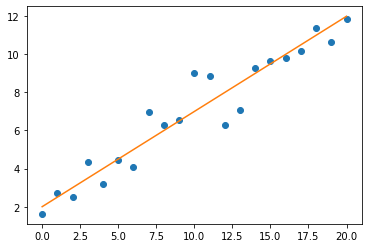

In [ ]:
x, y = get_data_set(0, 20, 21)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(x, y, 'o', x, x*0.5+2, '-')

We can clearly see that, while not being strictly linear, the points are positioned roughly along the line $\frac{1}{2}x+2$, and so we expect the solution to the TLS problem to have similar (but not identical) coefficients. We will also implement here the loss function $E_X$, which will later be used to measure the score for different solutions. 

In [ ]:
def E_X(x, y, a0, a1):
    return np.sum((a0+a1*x-y)**2)

## Solving the problem with singular value decomposition

Now let us look at the first approach to solving the TLS problem - singular value decomposition. First, we re-formulate the problem using matrices:

$$
A = 
\begin{bmatrix}
    1 & x_1\\
    1 & x_2\\
    1 & x_3\\
    \vdots & \vdots\\
    1 & x_n
\end{bmatrix}, 
z = 
\begin{bmatrix}
a_0\\
a_1\\
\end{bmatrix}, 
b = 
\begin{bmatrix}
y_1\\
y_2\\
y_3\\
\vdots\\
y_n
\end{bmatrix}
$$

then the loss function $E_X$ can be re-written as 

$$E_X(a_0, a_1) = E_X(z) = \left\lVert Az-b\right\rVert_2$$

Further, let $$A = U\Sigma V^*,\\ U\in\mathbb{R}^{n\times n}, \Sigma\in\mathbb{R}^{n\times2}, V\in\mathbb{R}^{2\times2}$$

Then according to *"Nela Bosner: Fast methods for large scale singular value decomposition (2006)"*, 

$$z = V\Sigma^{-1}U(:,1:n)^Tb$$

This is a very simple calculation using numpy, and the method *regress_via_svd()* implements it.

In [ ]:
def regress_via_svd(x, y):
    #calculate the linear regression of dataset (x(i), y(i)), i=1, 2,..., n via singular value decomposition
    #INPUT:
    #x is a column vector corresponding to the x-coordinates in the data set
    #y is a column vector corresponding to the y-coordinates in the data set
    #OUTPUT:
    #function returns the coefficients a1 and a0, such that the best approximation for the data set
    #is the line y(x) = x*a1 + a0
    
    n=len(x)
    A = np.zeros((n,2))
    A[:,0] = np.ones(n)
    A[:,1] = np.transpose(x)
    
    U, S, V = np.linalg.svd(A)
    
    solution = V@np.diag(S**-1)@np.transpose(U[:,0:2])@y
    return solution[0], solution[1]

Let's see the method at work, using the data set we generated previously. 

[2.1113995937962935, 0.4874957979055444]

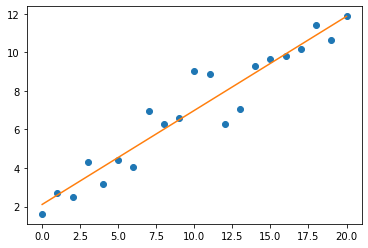

In [ ]:
a0_svd, a1_svd = regress_via_svd(x, y)
plt.plot(x, y, 'o', x, a0_svd+a1_svd*x, '-')
[a0_svd,a1_svd]

We can see that the optimal coefficients are $a_0\approx2$ and $a_1\approx0.5$, which was expected. 

## Solving the problem using gradient descent

Let us take another look at the loss function: 

$E_X(a_0, a_1) = \sum_{i=1}^{n}(a_0+a_1x-y_i)^2$

This is a real, convex function with two real variables, however we will omit the proof for the convex property here. 

The gradient descent method is a relatively simple concept. Starting from some point $(a_0^k, a_1^k)$, we calculate the gradient 

$$\overrightarrow{g_k} = \bigtriangledown E_X(a_0^k, a_1^k)$$ 

in that point. We then parametrize $E_X$ along the following ray:

$$t_k(s) = (t_0^k(s), t_1^k(s)) = (a_0^k + a_1^k) -s\overrightarrow{g_k}, s\in\mathbb{R}_+\\
p_k(s) = E_X(t_k(s))$$

Owing to the convex property of $E_X$, the curve $p_k$ has a global minimum in some point $(a_0, a_1)$. We set $(a_0^{k+1}, a_1^{k+1}) = (a_0, a_1)$ and repeat the process. 

This method converges for all starting points $(a_0^0, a_1^0)$, however it seems intuitive that a good starting point would be the line between $(x_1, y_1)$ and $(x_n, y_n)$. So we start from the point

$$\begin{split}
a_0^0 & = \frac{y_n-y_1}{x_n-x_1}x_1+y_1\\
a_1^0 & = \frac{y_n-y_1}{x_n-x_1}
\end{split}$$

Furthermore, we can easily calculate the gradient $\overrightarrow{g_k}$:

$$\overrightarrow{g_k} = (A_0^k, A_1^k) = \Big(2\sum_i(a_1^kx_i+a_0^k-y_i), 2\sum_i(x_i(a_1^kx_i+a_0^k-y_i)\Big),\\
p_k(s) = \sum_i\big(x_i(a_1^k-sA_1^k)+a_0^k-sA_0^k-y_i\big)^2$$

Thus, $p_k$ is a simple 2nd-degree polynomial, and we can easily find the point $s_k>0$ which minimizes it:

$$s_k = \frac{\sum_i(x_ia_1^k+a_0^k-y_i)(x_iA_1^k+A_0^k)}{\sum_i(x_iA_1^k+A_0^k)^2}$$

And so we obtain the point $(a_0^{k+1}, a_1^{k+1})$ by

$$(a_0^{k+1}, a_1^{k+1}) = (a_0^k, a_1^k) - s_kg_k = (a_0^k, a_1^k) - s_k(A_0^k, A_1^k)$$

This method is implemented in *regress_via_grad_des()*

In [ ]:
def regress_via_grad_des(x, y, max_iter=10, score_goal=0):
    #calculate the linear regression of dataset (x(i), y(i)), i=1, 2,..., n via singular value decomposition
    #INPUT:
    #x is a column vector corresponding to the x-coordinates in the data set
    #y is a column vector corresponding to the y-coordinates in the data set
    #n is the desired number of steps to take (default 10)
    #score_goal is an optional parameter - in case an optimal score for the loss function E_X is known in advance, 
    #then a certain accuracy may be demanded from the method (default 0). The method will still not progress beyond
    #n steps. 
    #OUTPUT:
    #function returns the coefficients a1 and a0, such that the best approximation for the data set
    #is the line y(x) = x*a1 + a0
    a1 = (y[-1]-y[0])/(x[-1]-x[0])
    a0 = a1*x[0]+y[0]
    for i in range(max_iter):
        A1 = np.sum(x*(a1*x+a0-y))
        A0 = np.sum(a1*x+a0-y)
        s = np.sum((x*A1+A0)*(x*a1+a0-y))/(np.sum((x*A1+A0)**2))
        a0, a1 = np.array([a0, a1]-s*np.array([A0, A1]))
        if score_goal > 0 and E_X(x, y, a0, a1) < score_goal: break
        
    return a0, a1

Let's see the method at work. We can also track each step and observe how quickly it converges to the optimal point. 

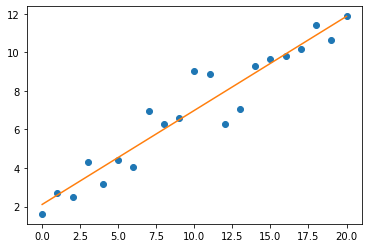

In [ ]:
a0_gd, a1_gd = regress_via_grad_des(x, y, 100, E_X(x, y, a0_svd, a1_svd))
plt.plot(x, y, 'C0o', x, a0_gd+a1_gd*x, 'C1-')

Using the loss function, $E_X$, we can measure the accuracy of each method, as well as track the accuracy for the gradient descent approach in each step. 

In [ ]:
score_svd = E_X(x, y, a0_svd, a1_svd)
score_gd = E_X(x, y, a0_gd, a1_gd)
print("SVD score: ", score_svd, "\nGD score: ", score_gd)
print("Difference (SD-GD): ", '{:.2e}'.format(score_svd-score_gd))

SVD score:  16.904686757486598 
GD score:  16.904686757552284
Difference (SD-GD):  -6.57e-11


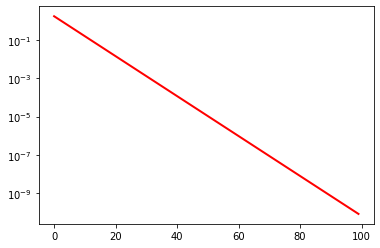

In [ ]:
score_gd_vec = np.zeros(100)
#track the score for regress_via_grad_des in each iteration
for i in range(len(score_gd_vec)):
    a0_temp, a1_temp = regress_via_grad_des(x, y, i)
    score_gd_vec[i] = E_X(x, y, a0_temp, a1_temp)

%matplotlib inline
plt.plot(range(len(score_gd_vec)), np.abs(score_gd_vec-score_svd), 'r-', lw=2)
plt.yscale('log')

We can clearly see that the accuracy of the GD method increases exponentially until stabilizing after about 60 iterations. Note that the accuracy here is measured as an absolute value versus the accuracy of the SVD method, which *isn't necessarily the perfect solution*, which explains the erratic behavior after those 60 iterations. 

A reasonable question to ask would be "which one is faster?" We will conduct a series of empirical tests for the two methods using various datasets. We will run each test using the SVD method first, and then demand that the GD method achieves an equal or better score each time. 

In [ ]:
import time

#conduct 1,000 tests using a set of 21 points
num_tests = 1000
num_points = 21
scores_svd = np.zeros(num_tests)
x_21 = np.zeros((num_tests, num_points))
y_21 = np.zeros((num_tests, num_points))
for i in range(num_tests):
    x_21[i,:], y_21[i,:] = get_data_set(0, 20, num_points)
    
t1 = time.time()
for i in range(num_tests):
    a0_temp, a1_temp = regress_via_svd(x_21[i,:], y_21[i,:])
    scores_svd[i] = E_X(x_21, y_21, a0_temp, a1_temp)
t2 = time.time()
t_svd_21 = t2-t1
print(t_svd_21, "s (", num_tests, "tests with", num_points, "points via SVD)")

t1 = time.time()
for i in range(num_tests):
    regress_via_grad_des(x_21[i,:], y_21[i,:], 100, scores_svd[i])
t2 = time.time()
t_gd_21 = t2-t1
print(t_gd_21, "s (", num_tests, "tests with", num_points, "points via GD)")

#conduct 1,000 tests using a set of 1,000 points
num_tests = 1000
num_points = 1000
scores_svd = np.zeros(num_tests)
x_1000 = np.zeros((num_tests, num_points))
y_1000 = np.zeros((num_tests, num_points))
for i in range(num_tests):
    x_1000[i,:], y_1000[i,:] = get_data_set(0, 20, num_points)
    
t1 = time.time()
for i in range(num_tests):
    a0_temp, a1_temp = regress_via_svd(x_1000[i,:], y_1000[i,:])
    scores_svd[i] = E_X(x_21, y_21, a0_temp, a1_temp)
t2 = time.time()
t_svd_1000 = t2-t1
print(t_svd_1000, "s (", num_tests, "tests with", num_points, "points via SVD)")

t1 = time.time()
for i in range(num_tests):
    regress_via_grad_des(x_1000[i,:], y_1000[i,:], 100, scores_svd[i])
t2 = time.time()
t_gd_1000 = t2-t1
print(t_gd_1000, "s (", num_tests, "tests with", num_points, "points via GD)")

0.15254688262939453 s ( 1000 tests with 21 points via SVD)
0.06877398490905762 s ( 1000 tests with 21 points via GD)
10.179675340652466 s ( 1000 tests with 1000 points via SVD)
0.12235069274902344 s ( 1000 tests with 1000 points via GD)


The results here are very lopsided - while the SVD approach took over 100 times as long to solve the harder test, while the time to solve the gradient descent algorithm with 1,000 points is less even than the time it took the SVD method to solve the easier problem, while simultaneously achieving greater accuracy. We will now compare the increase in time necessary to achieve the solution for either method, with respect to an increasing complexity of the problem (more points with each iteration). 

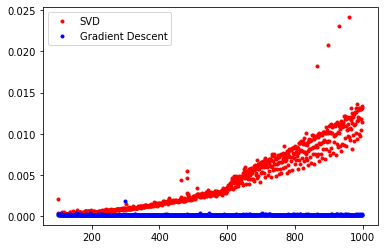

In [ ]:
num_tests = 1000
num_start = 100
t_svd = np.zeros(num_tests-num_start)
t_gd = np.zeros(num_tests-num_start)
for i in range(num_start, num_tests):
    x_temp, y_temp = get_data_set(n = i)
    t1 = time.time()
    a0, a1 = regress_via_svd(x_temp, y_temp)
    t2 = time.time()
    t_svd[i-num_start] = t2-t1
    score = E_X(x_temp, y_temp, a0_temp, a1_temp)
    t1 = time.time()
    regress_via_grad_des(x, y, 1000, score)
    t2 = time.time()
    t_gd[i-num_start]=t2-t1
    
plt.plot(range(num_start, num_tests), t_svd, 'r.', range(num_start, num_tests), t_gd, 'b.')
plt.legend(['SVD', 'Gradient Descent'])

In conclusion, while it isn't clear how the tests would compare in an n-dimensional scenario, gradient descent seems to clearly be the better approach when it comes to two-dimensional problems. 